In [1]:
using Plots, JuMP, Optim, GLPK, Ipopt, MathOptInterface

In [7]:
# Règle d'Armijo 
function armijo(f, df, g, x, d, c, itermax=50)
    α = 1
    i = 1
    ρ = .95
    
    while i < itermax
       if (f(x+α*d) <= f(x) + c*α*df'*d) & (all(g(x+α*d) .<= zeros(length(g(x)))))
            return α
        end
        α = ρ*α
        i = i+1
    end
    return nothing
end

armijo (generic function with 2 methods)

In [8]:
f(x) = 2x[1]^2+2x[2]^2-2x[1]*x[2]-4x[1]-6x[2]
#f(x,y) = 2x^2+2y^2-2x*y-4x-6y
df(x) = [4x[1]-2x[2]-4, 4x[2]-2x[1]-6]
g(x) = [x[1]+5x[2]-5, 2x[1]^2-x[2], -x[1], -x[2]]
dg(x) = [1 5; 4x[1] -1; -1 0; 0 -1]
#g(x,y) = [x+5y-5, 2x^2-y, -x, -y]

dg (generic function with 1 method)

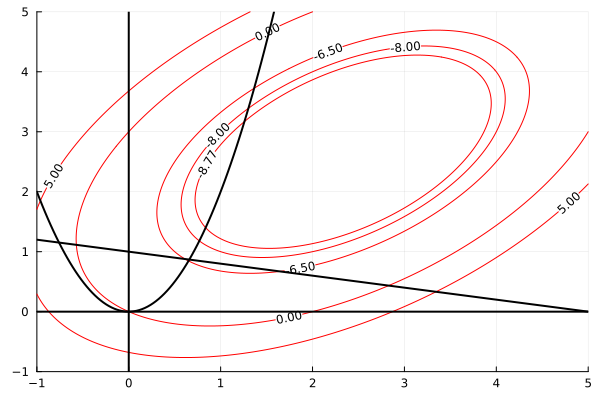

In [17]:
nx = 200
ny = 199
xx = range(-1,5, length=nx)
yy = range(-1,5, length=ny)
#ff = zeros(nx, ny)
ff(x,y) = 2x^2+2y^2-2x*y-4x-6y
gg = [(x,y)->x+5y-5, (x,y) -> 2x^2-y, (x,y) -> -x, (x,y) -> -y]

contour(xx, yy, ff, levels = [-8.77,-8, -6.5, 0.0, 5], color="red", colorbar = false, contour_labels=true)

# contour!(xx,yy,gg[1], levels=[0], color="black", linewidth=2 )
# contour!(xx,yy,gg[2], levels=[0], color="black", linewidth=2 )
# contour!(xx,yy,gg[3], levels=[0], color="black", linewidth=2 )
# contour!(xx,yy,gg[4], levels=[0], color="black", linewidth=2 )

for i in 1:4
    contour!(xx,yy,gg[i], levels=[0], color="black", linewidth=2 )
end
current() # nécessaire pour afficher le dessin après une boucle

In [18]:
modele = Model(Ipopt.Optimizer)
set_silent(modele)

# définition des variables
@variable(modele, x[1:2] >= 0)

# définition de la fonction objectif
@NLobjective(modele, Min, 2x[1]^2+2x[2]^2-2x[1]*x[2]-4x[1]-6x[2])

# définition des contraintes

@constraint(modele, x[1]+5x[2]-5 <= 0 )
@NLconstraint(modele, 2x[1]^2-x[2] <= 0)

# résolution du problème
optimize!(modele);

#affichage de la valeur optimale
@show objective_value(modele)

#affichage de la solution
println("solution = $(value.(x))")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

objective_value(modele) = -6.613085517226516
solution = [0.6588723497247925, 0.8682255395177734]


In [6]:
linearModel = Model(GLPK.Optimizer)
@variable(linearModel, -1 .<=d[1:2] .<=1)
@variable(linearModel, z)
@objective(linearModel, Min, z)
# set_objective_sense(linearModel, MathOptInterface.MIN_SENSE)
ϵ = 10^-6

1.0e-6

In [7]:
x = [0.0,0.75]
liste_iteres = [x]

1-element Vector{Vector{Float64}}:
 [0.0, 0.75]

In [8]:
ind = findall(abs.(g(x)) .<= ϵ)

1-element Vector{Int64}:
 3

In [9]:
@constraint(linearModel, conf, df(x)'*d <= z)

@constraint(linearModel, con, dg(x)[ind, :]*d .<= z);

In [10]:
conf 

conf : -5.5 d[1] - 3 d[2] - z ≤ 0.0

In [11]:
con

1-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 con : -d[1] - z ≤ 0.0

In [12]:
print(linearModel)

In [13]:
optimize!(linearModel)

In [14]:
value.(d), value(z)

([1.0, -1.0], -1.0)

In [15]:
α = armijo(f, df(x), g, x, value.(d), .5, 200)
println("α = $α")

α = 0.20390682574579033


In [16]:
x = x+α*value.(d) 
println("z = $(value(z))")
@show x 
append!(liste_iteres, [x])
unregister(linearModel,:conf)
delete(linearModel, conf)
unregister(linearModel, :con)
delete(linearModel, con)

z = -1.0
x = [0.20390682574579033, 0.5460931742542097]


# Méthode de Topkis-Veinott
C'est la même que la méthode de Zouteindijk sauf qu'à chaque itération on doit résoudre le programme linéaire suivant

\begin{equation*}
\begin{array}{l}
\displaystyle\mathop{\text{Minimiser }}_{(d,z)} z\\[.5mm]
\text{s.c.}\\
\nabla f(x)^\top d \leqslant z\\
\nabla g_i(x)^\top d - z \leqslant -g_i(x),\quad\text{pour }i=1,\ldots,m\\
\|d\|_\infty\leqslant 1.
\end{array}
\end{equation*}


In [351]:
linearModel = Model(GLPK.Optimizer)
@variable(linearModel, -1 .<=d[1:2] .<=1)
@variable(linearModel, z)
@objective(linearModel, Min, z)


z

In [352]:
x = [0.0,0.75]
liste_iteres = [x]

1-element Vector{Vector{Float64}}:
 [0.0, 0.75]

In [353]:
@constraint(linearModel, conf, df(x)'*d <= z)

@constraint(linearModel, con, dg(x)*d .<= z-g(x));

In [354]:
print(linearModel)

In [355]:
optimize!(linearModel)

In [356]:
value.(d), value(z)

([0.7142857142857144, -0.0357142857142857], -0.7142857142857143)

In [357]:
α = armijo(f, df(x), g, x, value.(d), .5, 200)
println("α = $α")

α = 0.8145062499999999


In [358]:
x = x+α*value.(d) 
println("z = $(value(z))")
@show x 
append!(liste_iteres, [x])
unregister(linearModel,:conf)
delete(linearModel, conf)
unregister(linearModel, :con)
delete(linearModel, con)

z = -0.7142857142857143
x = [0.5817901785714286, 0.7209104910714286]
